# LightGBM и интерпретация предсказаний

## 1 Импорт библиотек, инициализация глобальных констант

### 1.1 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from colorama import Fore, Back, Style
import warnings

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from lightgbm import log_evaluation
import shap

pd.set_option('display.max_columns', 50)
warnings.simplefilter('ignore')

### 1.2 Инициализация констант

In [2]:
# путь к папке с данными
path = Path('')
# название целевой переменной
TARGET_NAME = 'Approved'
# количество фолдов для кросс-валидации
N_FOLDS = 5
# random state для воспроизводимости
RANDOM_STATE = 42
# размер отложенной выборки
TEST_SIZE = 0.2

## 2 Подготовка данных

In [3]:
train = pd.read_csv(path / 'train_preprocessed.csv')
test = pd.read_csv(path / 'test_preprocessed.csv')
train

,ID,Gender,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved,Loan_Amount_per_Period,Credit_pct,Credit_pct_per_Period,Amount_over_pct,Amount_plus_pct,Amount_plus_pct_per_period,Amount_plus_pct_over_amount,Amount_pct_per_period,Credit_over_income,Credit_pct_over_income,Monthly_Income_in_city,Monthly_Income_at_employer,Monthly_Income_in_source_category,Monthly_Income_over_city_income,Monthly_Income_over_employeer_income,Monthly_Income_over_category_income,Age
0,APPC90493171225,Female,C10001,A,another,A,4.0,2000.0,B001,P,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13461.737114,2000.000000,4517.348356,0.148569,1.000000,0.442738,36
1,APPD40611263344,Male,C10003,A,COM0000002,C,1.0,3500.0,B002,P,Y,S122,G,0.0,20000.0,2.0,13.25,953.0,10,0,10000.0,2650.0,1325.000,7.547170,22650.0,11325.000,1.1325,0.566250,2.857143,0.378571,4130.332287,4789.257987,4517.348356,0.847389,0.730802,0.774791,29
2,APPE70289249423,Male,another,C,another,C,4.0,2250.0,B003,G,Y,S143,B,0.0,45000.0,4.0,NaN,NaN,0,0,11250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,3668.495833,2250.000000,6218.750490,0.613330,1.000000,0.361809,33
3,APPF80273865537,Male,another,C,another,A,4.0,3500.0,B003,G,Y,S143,B,0.0,92000.0,5.0,NaN,NaN,7,0,18400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.257143,NaN,1525.000000,2700.000000,6218.750490,2.295082,1.296296,0.562814,27
4,APPG60994436641,Male,C10002,A,another,A,4.0,10000.0,B001,P,Y,S134,B,2500.0,50000.0,2.0,NaN,NaN,10,0,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.500000,NaN,4465.358272,6644.750000,6218.750490,2.239462,1.504948,1.608040,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69708,APPU90955789628,Female,C10006,A,COM0000010,A,1.0,4900.0,B002,P,N,S122,G,0.0,NaN,NaN,NaN,NaN,10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4042.877278,5781.724828,4517.348356,1.212008,0.847498,1.084707,33
69709,APPV80989824738,Female,another,C,another,A,4.0,7190.1,B002,P,N,S122,G,1450.0,NaN,NaN,NaN,NaN,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4886.480000,7190.100000,4517.348356,1.471427,1.000000,1.591664,45
69710,APPW50697209842,Female,C10022,B,another,C,4.0,1600.0,B030,P,Y,S122,G,0.0,24000.0,4.0,35.50,943.0,2,0,6000.0,8520.0,2130.000,2.816901,32520.0,8130.000,1.3550,0.338750,3.750000,1.331250,3472.887186,1625.000000,4517.348356,0.460712,0.984615,0.354190,24
69711,APPY50870035036,Male,C10002,A,another,C,3.0,9893.0,B002,P,Y,S122,G,1366.0,80000.0,5.0,NaN,NaN,10,0,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.617305,NaN,4465.358272,3265.884615,4517.348356,2.215500,3.029195,2.190002,38


### 2.1 Используемые признаки при обучении

In [4]:
# используемые признаки при обучении
features = [
    c for c in train.columns if c != 'ID' and c != 'Approved'
    and c != 'Monthly_Income_in_source_category'
]
# численные признаки
num_features = train.select_dtypes(
    include=[int, float]).nunique()[lambda x: x > 25].index
# категориальные признаки
cat_features = list(set(features) - set(num_features))

Преобразуем категориальные признаки к типу category

In [5]:
train[cat_features] = train[cat_features].astype('category')
test[cat_features] = test[cat_features].astype('category')

## 2.2 Отложенная выборка

In [6]:
tr_data, te_data = train_test_split(train,
                                    test_size=TEST_SIZE,
                                    random_state=RANDOM_STATE,
                                    stratify=train[TARGET_NAME])
tr_data = tr_data.reset_index(drop=True)

## 3 Функция для обучения модели

In [7]:
def lgb_training(train_df, params, features, test_df=None, verbose=250):
    """
    Функция для обучения модели.
    
    Параметры
    ----------
    train_df - обучающая выборка
    params - набор гиперпараметров
    features - признаки
    test_df - тестовая выборка
    verbose - вывод результатов
    
    Возвращает
    -------
    score_list - roc-auc на кросс-валидации для каждого фолда
    test_preds - предсказания на тестовой выборке, если тестовая выборка задана
    iterations - количество итераций на каждом фолде
    """
    categorical_feature = list(set(features) & set(cat_features))
    test_preds = []
    if test_df is not None:
        test_preds = np.zeros(len(test_df))
        test_df = test_df[features]
    target = train_df.loc[:, TARGET_NAME].values

    score_list = []
    iterations = []
    kf = StratifiedKFold(n_splits=N_FOLDS,
                         shuffle=True,
                         random_state=RANDOM_STATE)
    for fold, (train_index, val_index) in enumerate(kf.split(train_df,
                                                             target)):
        X_train = train_df.loc[train_index, features]
        X_val = train_df.loc[val_index, features]
        y_train = target[train_index]
        y_val = target[val_index]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_valid = lgb.Dataset(X_val, y_val)

        callbacks = [lgb.log_evaluation(period=verbose)]
        model = lgb.train(params=params,
                          train_set=lgb_train,
                          categorical_feature=categorical_feature,
                          num_boost_round=15000,
                          valid_sets=[lgb_train, lgb_valid],
                          callbacks=callbacks)

        preds = model.predict(X_val)
        score = roc_auc_score(y_val, preds)

        if test_df is not None:
            test_preds += model.predict(test_df) / kf.n_splits

        if verbose:
            print(
                f"{Fore.BLACK}{Style.BRIGHT}FOLD: {fold}, ROC-AUC: {score:.5f} {Style.RESET_ALL}"
            )
        score_list.append(score)

        n_iterations = model.best_iteration
        iterations.append(n_iterations)

    return score_list, test_preds, iterations

## 4 Обучение модели

In [8]:
params = {
    'objective': 'binary',
    'metric': 'AUC',
    'early_stopping_round': 100,
    'random_state': RANDOM_STATE,
    'verbose': -1,
    'learning_rate': 0.01,
    'num_leaves': 15,
    'colsample_bytree': 0.4,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
}

In [9]:
oof_score, holdout_pred, n_iter = lgb_training(tr_data, params, features,
                                               te_data)
print(f"{Fore.GREEN}{Style.BRIGHT}\nROC-AUC на кросс-валидации: {np.mean(oof_score):.5f} +- {np.std(oof_score):.5f}")
print(f"{Fore.RED}ROC-AUC на отложенной выборке: {roc_auc_score(te_data[TARGET_NAME],holdout_pred):.5f}{Style.RESET_ALL}")

[250]	training's auc: 0.929352	valid_1's auc: 0.844971
[500]	training's auc: 0.955827	valid_1's auc: 0.847043
[750]	training's auc: 0.970589	valid_1's auc: 0.847106
FOLD: 0, ROC-AUC: 0.84768 
[250]	training's auc: 0.928504	valid_1's auc: 0.854028
[500]	training's auc: 0.956355	valid_1's auc: 0.857404
FOLD: 1, ROC-AUC: 0.85817 
[250]	training's auc: 0.926995	valid_1's auc: 0.843846
[500]	training's auc: 0.955644	valid_1's auc: 0.851627
[750]	training's auc: 0.97174	valid_1's auc: 0.85382
FOLD: 2, ROC-AUC: 0.85461 
[250]	training's auc: 0.926159	valid_1's auc: 0.87053
FOLD: 3, ROC-AUC: 0.87208 
[250]	training's auc: 0.930817	valid_1's auc: 0.850217
FOLD: 4, ROC-AUC: 0.85041 

ROC-AUC на кросс-валидации: 0.85659 +- 0.00853
ROC-AUC на отложенной выборке: 0.83747


## 5 Интерпретация предсказаний

Переобучим модель на всем тренировочном датасете

In [10]:
params['metric'] = None
params['early_stopping_round'] = None

In [11]:
model = lgb.train(params=params,
                  train_set=lgb.Dataset(tr_data[features],
                                        tr_data[TARGET_NAME]),
                  categorical_feature=cat_features,
                  num_boost_round=int(np.median(n_iter) + 1),
                  callbacks=[lgb.log_evaluation(period=0)])

[SHAP value](https://www.youtube.com/watch?v=FEg7JiubxLU):
*  по горизонтали расположены признаки
*  каждая точка на графике - один объект выборки
*  признаки на графике упорядочены по важности (чем выше, тем важнее признак)
*  серым цветом на графике отмечены категориальные переменные


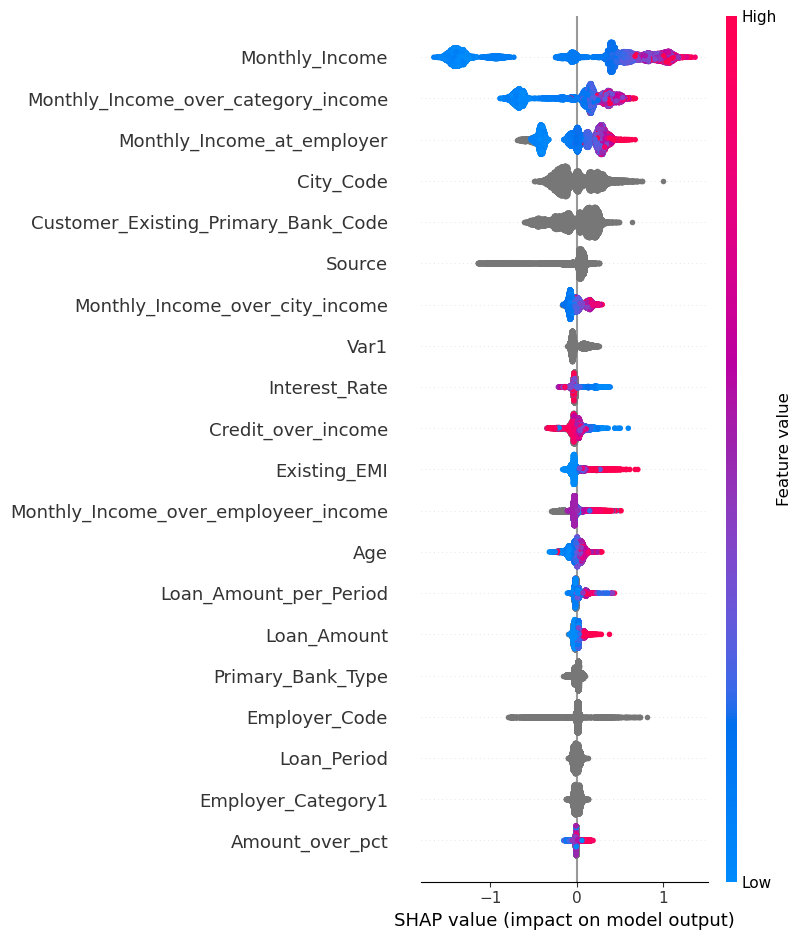

In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(te_data[features])
shap.summary_plot(shap_values[1], te_data[features])

##### Интерпретация некоторых предсказаний модели:
*  Чем больше значение месячного дохода (Monthly Income), тем больше вероятность, что кредит будет одобрен. При низких значения дохода кредит почти наверняка выдан не будет.
*  Чем больше отношения запрошенной суммы кредита к месячному доходу (Credit_over_income), тем ниже вероятность, что кредит будет выдан. С учетом того, что клиент будет каждый месяц тратить определенный процент от своей зарплаты на постоянные расходы (оплата жилья, продукты), у него должна оставаться определенная сумма, чтобы погасить кредит. Если же клиент с низкой зарплатой берет большую сумму кредита, то есть вероятность, что у него могут возникнуть другие расходы и клиент не сможет исправно погашать долг.
*  Чем выше выплаты по существующим кредитам, тем больше вероятность, что кредит будет одобрен. Возможно, большие выплаты либо у тех, кто хочет быстрее погасить кредит, либо, например, кредит берется для бизнеса, в таком случае большие выплаты из-за суммы кредита. Если человек хочет быстрее погасить кредит, то ему нет смысла не платить по нему. Если же кредит берется для бизнеса, то возможно, он берется под залог, и в таком случае слишком велики риски, если кредит не выплачивать
*  Чем выше возраст клиента, тем больше вероятность, что ему будет одобрен кредит. Возможно, здесь руководствуются тем, что люди в возрасте имеют большой опыт работы, как следствие, должна быть ваше зарплата.
*  Чем выше сумма кредита, тем больше вероятность, что его одобрят. Возможно, банк не хочет терять потенциально лакомый кусок и поэтому одобряет такие кредиты.
*  Банк неохотно одобряет кредит с низкой процентной ставкой. Думаю, это попросту невыгодно, клиент будет пользоваться деньгами, а взамен приносить мало прибыли